In [1]:
import tellurium as te
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline 

/usr/lib/python2.7/dist-packages/tellurium/notebooks/__init__.py:16: UserWarning: Notebook tools are not imported, due to missing dependencies.
  warnings.warn("Notebook tools are not imported, due to missing dependencies.")


['time',
 'V_tot_fl',
 '[c_e]',
 '[c_i]',
 'pi_i',
 'pi_e',
 'R_ref',
 'r',
 'r_os',
 'r_b',
 'pi_t',
 'V_ref']

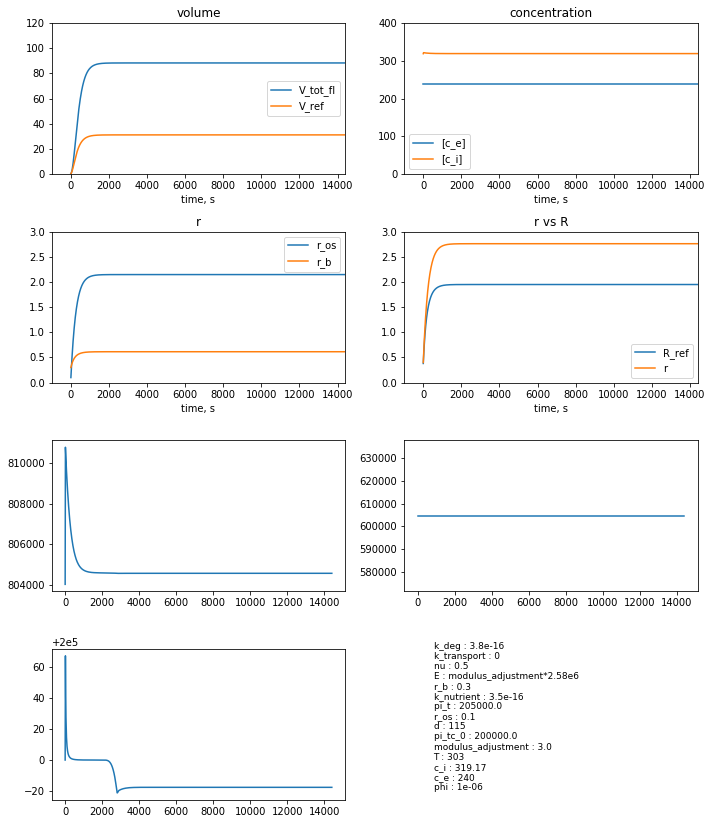

In [2]:
model=te.loadAntimonyModel('volume_reference_radius.txt')
model_species=['time','V_tot_fl', '[c_e]', '[c_i]','pi_i','pi_e', 'R_ref', 'r','r_os', 'r_b', 'pi_t', 'V_ref']
end_time = 14400
sim=model.simulate(1, end_time, 1000, selections = model_species)

#tom
'''model=te.loadAntimonyModel('volume_tom.txt')
model_species_tom=['time','V_tot_fl', '[c_e]', '[c_i]','pi_i','pi_e','pi_t',]
sim=model.simulate(1,15000,1000, selections = model_species_tom)
'''



fig1=plt.figure(1, figsize=(10,20))

variables = sim.colnames
number_of_variables = len(variables)
k=0


paras_dic={}
paras_dic={'r_b': 0.3,
           'r_os': 0.1,
           'c_e': 240,
           'c_i' : 319.17,
           'T': 303,
           'pi_t': 0.205e6,
           'pi_tc_0' : 0.2e6,
           'd': 115,
           'phi' : 1.e-6,
           'nu' : 0.5,
           'modulus_adjustment': 3.0,
           'E' : 'modulus_adjustment*2.58e6',
           'k_nutrient' : 3.5e-16,
           'k_deg' : 3.8e-16,
           'k_transport' : 0 
  }

def plot_details(var,title, max_y):
    plt.title(title)
    plt.xlim(-1000, end_time)
    plt.ylim(0,max_y)
    plt.xlabel('time, s') 
    plt.legend()

# Plot

fig1=plt.figure(1, figsize=(10,20))

for var in variables:
    
    if var == 'time':
        continue
    if var.startswith('V'):
        plt.subplot(number_of_variables/2 + 1,2, 1)
        plt.plot(sim['time'],sim[var], label =var)
        plot_details(var, 'volume' ,120)
        
    elif var.startswith('[c'):
        plt.subplot(number_of_variables/2 + 1,2, 2)
        plt.plot(sim['time'],sim[var], label = var)
        plot_details(var, 'concentration' , 400)

    elif var.startswith('r_'):
        plt.subplot(number_of_variables/2 + 1,2, 3)
        plt.plot(sim['time'],sim[var], label = var)
        plot_details(var, 'r' , 3)
 
        #plt.ylim(0,100) 
    elif var in ['r', 'R_ref']:
        plt.subplot(number_of_variables/2 + 1,2, 4)
        plt.plot(sim['time'],sim[var], label = var)
        plot_details(var, 'r vs R' , 3)

    else:    
        k+=1
        plt.subplot(number_of_variables/2 + 1,2, 4+k)    
        plt.plot(sim['time'],sim[var], label =var)
        #plot_details(var, var ,4e5)

ax = plt.subplot(number_of_variables/2 + 1,2, 4+k+1)
ax.axis('off')

for pos,key in enumerate(paras_dic):
    ax.text(0.1, 1./len(paras_dic)*(pos+1), key  + ' : ' + str(paras_dic[key]), fontsize=9)
   
    plt.tight_layout()

plt.savefig('plots/simulation__refradius_osmo.png',dpi=300)
variables

In [3]:
model=te.loadAntimonyModel('volume_reference_radius.txt')
model_species=['time','V_tot_fl', '[c_e]', '[c_i]','pi_i','pi_e', 'R_ref', 'r','r_os', 'r_b', 'pi_t', 'V_ref']
end_time = 14400
sim=model.simulate(1, end_time, 1000, selections = model_species)



In [ ]:

def plot_simulation(sim, groups):
    for var in sim.colnames:
        
    
    

In [10]:
groups = {'volume': ['V_tot_fl', 'V_ref'],
          'concentration': ['[c_e]', '[c_i]'],
          'radius': ['r_os', 'r_b']}

In [5]:
sim.colnames


['time',
 'V_tot_fl',
 '[c_e]',
 '[c_i]',
 'pi_i',
 'pi_e',
 'R_ref',
 'r',
 'r_os',
 'r_b',
 'pi_t',
 'V_ref']

In [12]:
groups.values

<function values>